In [1]:
from GeneratePolygons import generate_batch
import numpy as np
import matplotlib.pyplot as plt
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
%matplotlib inline

In [2]:
train_imgs=[]
train_labels=[] #the generating grammar, encoded as a space-separated string
test_imgs=[]
test_labels=[] 
sides_range=[3,4,5,6,7,8,9,10] #images will be polygons with number of sides being one of the numbers in this list

n_train=1500 #number of training images in each class
n_test=500
for class_id,n_sides in enumerate(sides_range):
    imgs=generate_batch(n_train+n_test,n_sides,edge_width=2)
    train_imgs.append(imgs[:n_train])
    test_imgs.append(imgs[n_train:])
    #the generative rules; T is used as terminal symbol; each ek corresponds to the relation between sides in k-sided polygon
    train_labels+=[(f'S -> S + e{n_sides} , S -> S + T')]*n_train
    test_labels+=[(f'S -> S + e{n_sides} , S -> S + T')]*n_test
train_imgs=np.vstack(train_imgs)
test_imgs=np.vstack(test_imgs)
train_labels=np.array(train_labels)
test_labels=np.array(test_labels)

In [3]:
TEXT = torchtext.data.Field(tokenize=get_tokenizer("basic_english"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)



In [4]:
TEXT.build_vocab([x.split(' ') for x in train_labels])

In [5]:
MAX_SEQ_LEN=16 #pad sequences so they are all this length

def str_to_int(s,max_len=MAX_SEQ_LEN):
    #s a string of tokens separated by spaces
    #return representation as sequence of integers
    #if length is < max_len, then add padding token at the end until it is this length
    char_as_int=[TEXT.vocab.stoi[x] for x in s.split(' ')]

    char_as_int=char_as_int[:MAX_SEQ_LEN]+[len(TEXT.vocab)]*max(MAX_SEQ_LEN-len(char_as_int),0) #pad
    return char_as_int
    
def str_to_onehots(s,max_len=MAX_SEQ_LEN):
    #s a string of tokens separated by spaces
    #return representation as sequence of one-hot vectors 
    #if length is < max_len, then add padding token at the end until it is this length
    
    char_as_int=str_to_int(s,max_len=max_len)


    ret=torch.zeros((max_len,len(TEXT.vocab)+1))
    for i,x in enumerate(char_as_int):
        ret[i,x]=1
    return ret

In [6]:
#convert each label to a sequence of one-hots
train_seqs=[str_to_int(x) for x in train_labels]
test_seqs=[str_to_int(x) for x in test_labels]


In [7]:
class GrammarGenerator(torch.nn.Module):
    def __init__(self, n_classes,input_size=(128,128)):
        super(GrammarGenerator, self).__init__()
        # Convolution 1
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=8, stride=1, padding=3)

        # Max pool 1
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=4)
        
        self.conv2 = torch.nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=3)

        # Max pool 1
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)

        #dimensionality of lstm
        self.emb_dim=100
        self.h_dim=100 
        self.fc1=torch.nn.Linear(10*17*17,self.emb_dim)
        self.fc2=torch.nn.Linear(10*17*17,self.h_dim)
        self.fc3=torch.nn.Linear(10*17*17,self.h_dim)
        
        self.lstm = torch.nn.LSTM(self.emb_dim, self.h_dim)  
        self.tokenW=torch.nn.Linear(self.emb_dim+2*self.h_dim,len(TEXT.vocab)+1) #weights for decoding token from hidden state and embedding 

    def forward(self, x):
        #pass through conv layers
        outp=self.maxpool1(self.conv1(x))
        outp=torch.nn.ReLU()(outp)
        outp=self.maxpool2(self.conv2(outp))
        outp=torch.nn.ReLU()(outp)
        outp=torch.reshape(outp,(len(x),-1)) #concatenate so each image is represented by a 1d vector
        
        
        embs=[torch.nn.ReLU()(self.fc1(outp))[None,:,:]] #initialize lstm embedding  (extra axis for sequence dimsnion)
        
        h1s=[torch.nn.ReLU()(self.fc2(outp))[None,:,:]] #initialize lstm hidden state
        h2s=[torch.nn.ReLU()(self.fc3(outp))[None,:,:]]
        
        #run through lstm and record embeddings and hidden state
        for i in range(MAX_SEQ_LEN-1):
            new_emb,new_h=self.lstm(embs[-1],(h1s[-1],h2s[-1]))
            embs.append(new_emb)
            h1s.append(new_h[0])
            h2s.append(new_h[1])
        
        embs=torch.cat(embs,axis=0)
        h1s=torch.cat(h1s,axis=0)
        h2s=torch.cat(h2s,axis=0)
        
        #concatenate all together to decode the corresponding tokens
        features=torch.cat((embs,h1s,h2s),axis=2)
        
        features=self.tokenW(features) #logit for each token 
        
        
        return features.transpose(1,0) #reorder so batch dim is first


In [8]:
model=GrammarGenerator(len(sides_range))

In [9]:
batch_size=32
optimizer=torch.optim.SGD(model.parameters(),lr=.005)
criterion=torch.nn.CrossEntropyLoss()#weight=weights).to('cuda')
losses=[]


In [143]:
#train
for ii in range(1000):
    batch_ids = np.random.choice(train_imgs.shape[0], batch_size, replace=False)
    optimizer.zero_grad()

    feats=model(torch.from_numpy(train_imgs[batch_ids])[:,None,:,:].float())
    feats=feats.reshape(-1,feats.shape[2])
    #stack so that first axis is (first token in seq 1, ..., nth tokenin seq 1, first token in seq 2, ... nth in seq 2, ...)

    #list the token ids of the target sequences in the same order (first all seq1, then seq2, etc.)
    targets=torch.Tensor(sum([train_seqs[x] for x in batch_ids],[])).long()
    loss=criterion(feats, targets)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy())
    if(ii%25==0):
        print(losses[-1])

0.05557102
0.06670468
0.07374934
0.062045693
0.0713961
0.08095186
0.065995805
0.07357559
0.070339195
0.06917813
0.044885352
0.05646165
0.07942738
0.06310578
0.043154303
0.045281224
0.057252172
0.0763328
0.10348054
0.067855485


KeyboardInterrupt: 

(0, 0.2)

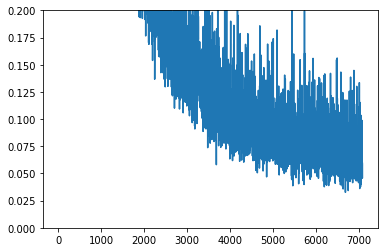

In [145]:

plt.plot(losses)
plt.ylim(0,.2)



In [17]:
#predictions on test images

In [146]:
predicted_grammars=[]

extended_vocab=TEXT.vocab.itos+['<pad>']
for x in test_imgs:
    outp=model(torch.from_numpy(x)[None,None,:,:].float()).squeeze()
    pred_seq=torch.argmax(outp,axis=1)
    pred_seq=[extended_vocab[c]+' ' for c in pred_seq]
    predicted_grammars.append(''.join(pred_seq))

In [147]:
ids=np.random.choice(len(test_labels),10,replace=False) #pick some images randomly to show
[predicted_grammars[x] for x in ids] #predicted grammar for each image

['S -> S + e9 , S -> S + T <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e3 , S -> S + T <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e9 , S -> S + T <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e6 , S -> S + T <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e9 , S -> S + T <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e6 , S -> S + T <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e9 , S -> S + T <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e3 , S -> S + T <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e9 , S -> S + T <pad> <pad> <pad> <pad> <pad> ',
 'S -> S + e4 , S -> S + T <pad> <pad> <pad> <pad> <pad> ']

In [148]:
[test_labels[x] for x in ids]#true grammars for the images

['S -> S + e9 , S -> S + T',
 'S -> S + e3 , S -> S + T',
 'S -> S + e9 , S -> S + T',
 'S -> S + e7 , S -> S + T',
 'S -> S + e9 , S -> S + T',
 'S -> S + e8 , S -> S + T',
 'S -> S + e10 , S -> S + T',
 'S -> S + e3 , S -> S + T',
 'S -> S + e10 , S -> S + T',
 'S -> S + e4 , S -> S + T']

In [149]:
predicted_sides=[np.where([f'e{i}' in pg for i in sides_range])[0] for pg in predicted_grammars]
predicted_sides=[x[0] if len(x)>0 else -1 for x in predicted_sides ]

In [150]:
true_sides=[np.where([f'e{i}' in pg for i in sides_range])[0][0] for pg in test_labels]


In [151]:
C=np.zeros((len(sides_range)+1,len(sides_range)))
conj,counts=np.unique(np.vstack((np.array(predicted_sides),np.array(true_sides))).T,axis=0,return_counts=True)
for a,b in zip(conj,counts):
    if(a[0]==-1):
        C[C.shape[0]-1,a[1]]=b
    C[a[0],a[1]]=b

Text(0.5, 15.0, 'actual')

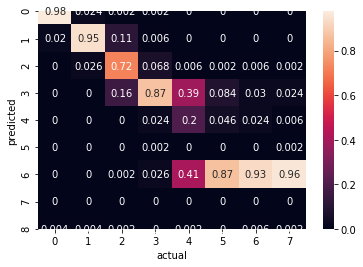

In [152]:
import seaborn as sns
sns.heatmap(C/np.sum(C,axis=0)[None,:],annot=True)
plt.ylabel('predicted')
plt.xlabel('actual')

In [153]:
np.mean(np.array(true_sides)==np.array(predicted_sides)) #test accuracy

0.58125